## Задание

Провести А/А-тест и убедиться в том, что система сплитования работает корректно.

Провести А/А-тест с '2024-05-24' по '2024-05-30'. Сделать симуляцию, как будто мы провели 10000 А/А-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом. 

Что ожидаем в ответе:
- Построить гистограмму распределения получившихся 10000 p-values.

- Посчитать, какой процент p values оказался меньше либо равен 0.05

- Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования. При выполнении задания важно обосновать и аргументировать ваш вывод.

<Axes: ylabel='Count'>

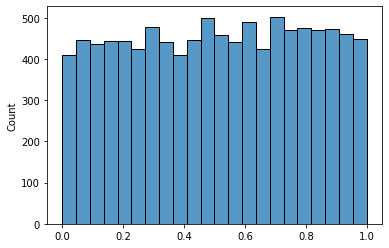

In [1]:
import pandahouse as pandahouse
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import poisson
from scipy import stats

#подключение к clickhouse
connection = {
    'host': 'https://clickhouse.lab.karpov.courses/',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240620'
}

qq = """
select exp_group,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
from {db}.feed_actions
where toDate(time) >= '2024-05-24' and toDate(time) <= '2024-05-30'
    and exp_group in (2,3)
group by exp_group, user_id
"""

df = pandahouse.read_clickhouse(qq, connection=connection)
    

stat_test = []
for i in range(10000):
    subgroup_2 =  df[df.exp_group == 2].ctr.sample(500)
    subgroup_3 =  df[df.exp_group == 3].ctr.sample(500)
    ttest = stats.ttest_ind(subgroup_2, subgroup_3, equal_var=False) 
    stat_test.append(ttest[1])
    
sns.histplot(stat_test, kde=False)

In [9]:
count = 0
for j in stat_test:
    if j <= 0.05:
        count += 1

percentage = count/len(stat_test)*100
print('p_value <= 0.05 составляет ', percentage, '%')

p_value <= 0.05 составляет  4.79 %


Система сплитования работает корректно. Те значения p-value, которые меньше или равны 0.05 составляет ~5%. Это говорит о том, что в 5% случаев средние наших выборок неравны. 
Т.о принимаем нулевую гипотезу и делаем вывод, что группы 2 и 3 одинаковые.